# Deconvolution Cython

Use cython to accelerate deconvolution

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [3]:
import FEE as FE

In [4]:
from scipy import signal

In [5]:
import time

In [6]:
import pandas as pd

In [7]:
%load_ext Cython

The Cython module is not an IPython extension.


In [8]:
import cBLR as BLR

In [9]:
from cBLR import deconvolve_signal_acum

In [10]:
from Database import loadDB

## Revised on:

In [11]:
print(time.strftime("%d/%m/%Y"))

10/11/2016


In [12]:
print(time.strftime("%H:%M:%S"))

15:59:23


In [13]:
def wait():
    """
    A simple convenience name for raw_input
    """
    raw_input("Press a key...")

In [14]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


### Deconvolution function

#### coeff_clean = freq_zerod

Nominal values:


C1=3100 nF

R1=1567 ohm

f_sample = (1/25 ns)

freq_zero = 1/(R1*C1);

freq_zerod = freq_zero / (f_sample*np.pi)

#### coef_blr=fee.freq_LHPFd*np.pi

freq_LHPFd = freq_LHPF/(f_sample*np.pi)

freq_LHPF = 1./(R * C)

#### List the files

In [15]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Na_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.1250.0keV.z250mm.next_10.root.h5
electrons.1250.0keV.z250mm.next_100.root.h5
electrons.1250.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10.root.h5
electrons.2500.0keV.z250mm.next_100.root.h5
electrons.2500.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10.root.h5
electrons.40.0keV.z250mm.next_100.root.h5
electrons.40.0keV.z250mm.next_1000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5
run_2609_kr.root.h5
run_2644.gdc1next.000.next1el_2644.root.h5
run_2644.gdc1next.001.next1el_2644.root.h5
run_2644.gdc1next.003.next1el_2644.roo

#### Open and inspect files

In [15]:
e2644 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2644.gdc1next.000.next1el_2644.root.h5','r+')

In [16]:
kr2609 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2609_kr.root.h5','r+')

## Calibration data

In [16]:
pmtID = ['1','3','2','4','C','B','A','9','8','7','6','5']
elecID = [0,18,1,19,27,26,9,8,23,22,5,4]
noise_rms = [0.706,0.8744,0.7213,0.7624,0.7921,0.866,0.7062,0.7278,0.7303,0.716,0.7323,0.7206]
coef_c = [2.905447E-06,3.08E-06,2.8006E-06,2.756265E-06,3.138766E-06,3.965176E-06,2.711E-06,
          3.127641E-06,3.064543E-06,3.040463E-06,3.113604E-06,3.185979E-06]
coef_blr = [1.632411E-03,1.632411E-03,1.611104E-03,1.599356E-03,1.566958E-03,1.649618E-03,
            1.592963E-03,1.612068E-03,1.600683E-03,1.592718E-03,1.575192E-03,1.596322E-03]

In [17]:
dataPMT = pd.DataFrame({'pmtID': pmtID,'elecID': elecID,'noise_rms': noise_rms,
              'coef_c': coef_c,'coef_blr': coef_blr})

In [18]:
dataPMT

,coef_blr,coef_c,elecID,noise_rms,pmtID
0,0.001632,0.000003,0,0.7060,1
1,0.001632,0.000003,18,0.8744,3
2,0.001611,0.000003,1,0.7213,2
3,0.001599,0.000003,19,0.7624,4
4,0.001567,0.000003,27,0.7921,C
5,0.001650,0.000004,26,0.8660,B
6,0.001593,0.000003,9,0.7062,A
7,0.001612,0.000003,8,0.7278,9
8,0.001601,0.000003,23,0.7303,8
9,0.001593,0.000003,22,0.7160,7


In [17]:
loadDB.DataPMT()

,sensorID,channel,pmtid,active,x,y,deconvClean,deconvCoeff,adc_to_pes,noise_rms
0,0,0,1,1,-23.941401,65.778503,0.000003,0.001632,-22.9168,0.7060
1,1,18,3,1,-44.995098,-53.623100,0.000003,0.001632,-23.7510,0.8744
2,2,1,2,1,68.936501,-12.155400,0.000003,0.001611,-25.3008,0.7213
3,3,19,4,1,0.000000,185.000000,0.000003,0.001599,-25.9984,0.7624
4,4,27,C,1,-118.916000,141.718002,0.000003,0.001567,-23.7074,0.7921
5,5,26,B,1,-182.188995,32.124901,0.000004,0.001650,-20.8927,0.8660
6,6,9,A,1,-160.214996,-92.500000,0.000003,0.001593,-22.1340,0.7062
7,7,8,9,1,-63.273701,-173.843002,0.000003,0.001612,-33.0993,0.7278
8,8,23,8,1,63.273701,-173.843002,0.000003,0.001601,-20.4377,0.7303
9,9,22,7,1,160.214996,-92.500000,0.000003,0.001593,-25.1698,0.7160


In [18]:
dataPMT  = loadDB.DataPMT()

In [19]:
dataPMT

,sensorID,channel,pmtid,active,x,y,deconvClean,deconvCoeff,adc_to_pes,noise_rms
0,0,0,1,1,-23.941401,65.778503,0.000003,0.001632,-22.9168,0.7060
1,1,18,3,1,-44.995098,-53.623100,0.000003,0.001632,-23.7510,0.8744
2,2,1,2,1,68.936501,-12.155400,0.000003,0.001611,-25.3008,0.7213
3,3,19,4,1,0.000000,185.000000,0.000003,0.001599,-25.9984,0.7624
4,4,27,C,1,-118.916000,141.718002,0.000003,0.001567,-23.7074,0.7921
5,5,26,B,1,-182.188995,32.124901,0.000004,0.001650,-20.8927,0.8660
6,6,9,A,1,-160.214996,-92.500000,0.000003,0.001593,-22.1340,0.7062
7,7,8,9,1,-63.273701,-173.843002,0.000003,0.001612,-33.0993,0.7278
8,8,23,8,1,63.273701,-173.843002,0.000003,0.001601,-20.4377,0.7303
9,9,22,7,1,160.214996,-92.500000,0.000003,0.001593,-25.1698,0.7160


## Testing new deconvolution with Kripton data

In [21]:
pmtrwf = kr2609.root.RD.pmtrwf

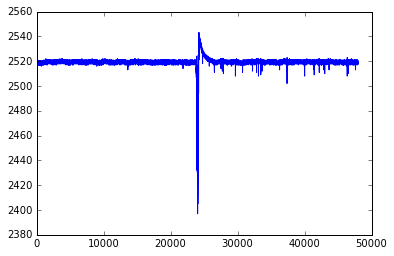

In [19]:
plt.plot(pmtrwf[0,0])

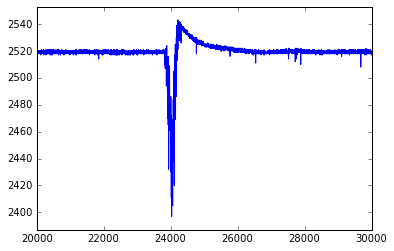

In [20]:
mpl.plts(pmtrwf[0,0], signal_start=20000, signal_end=30000, offset=10)

In [22]:
pmtrwf.dtype

dtype('int16')

## ACUMULATOR-Controlled algorithm

In [22]:
signal_r, acum = deconvolve_signal_acum(pmtrwf[0,0],n_baseline=500,
                                  coef_clean=dataPMT['deconvClean'][0], 
                                  coef_blr=dataPMT['deconvCoeff'][0], 
                                  noise_rms = dataPMT['noise_rms'][0],
                                  thr_trigger=5, thr_acum=800,
                                  coeff_acum = 0.9995)

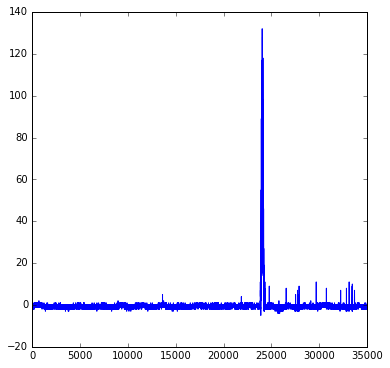

In [23]:
xmin = 0
xmax = 35000
plt.figure(figsize=(6, 6))
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])

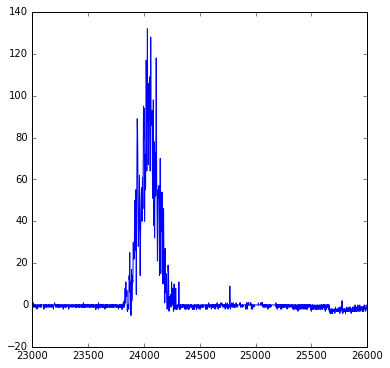

In [24]:
xmin = 23000
xmax = 26000
plt.figure(figsize=(6, 6))
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])

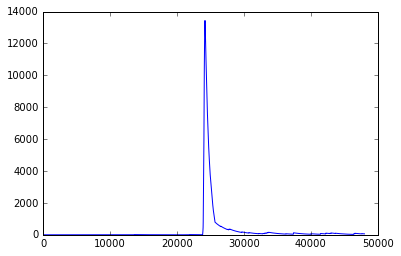

In [25]:
plt.plot(acum)

In [26]:
pmtrwf = kr2609.root.RD.pmtrwf

In [ ]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 7, thr2=1, thr3=0.5, mau_len=128, 
           xmin=20000,
           xmax=30000, event=0)

In [ ]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 7, thr2=1, thr3=1.0, mau_len=128, 
           xmin=20000,
           xmax=30000, event=0)

The best values for thr3 appear to be 0.3-0.5

### With acumulator controlled

In [102]:
pmtrwf = kr2609.root.RD.pmtrwf

PMT number 1
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411


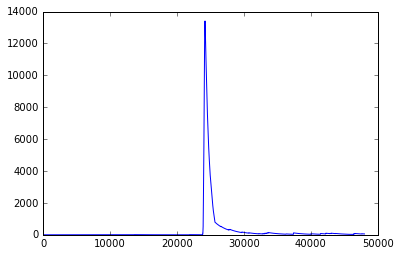

Press a key...


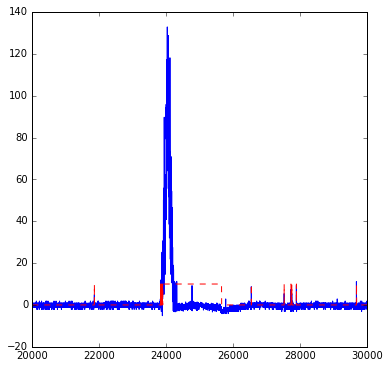

Press a key...
PMT number 2
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 1 with coef_clean = 3.08e-06 coef_blr = 0.001632411


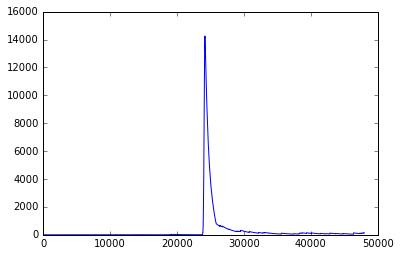

Press a key...


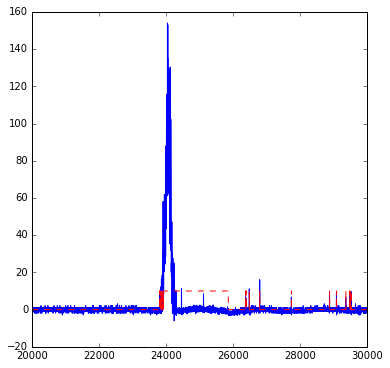

Press a key...
PMT number 3
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 2 with coef_clean = 2.8006e-06 coef_blr = 0.001611104


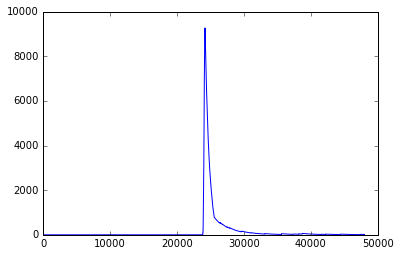

Press a key...


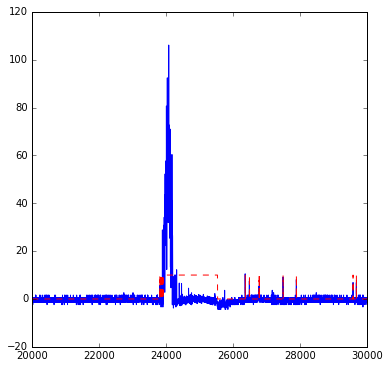

Press a key...
PMT number 4
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 3 with coef_clean = 2.756265e-06 coef_blr = 0.001599356


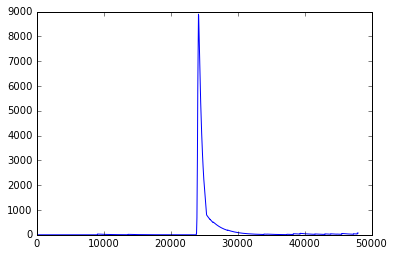

Press a key...


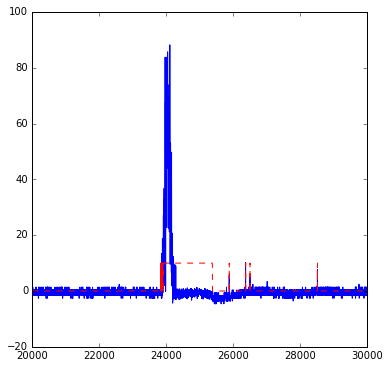

Press a key...
PMT number 5
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 4 with coef_clean = 3.138766e-06 coef_blr = 0.001566958


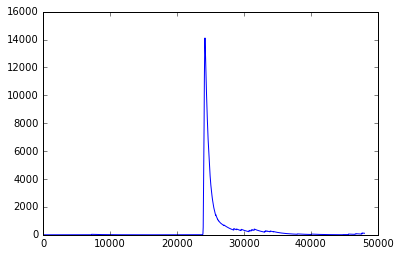

Press a key...


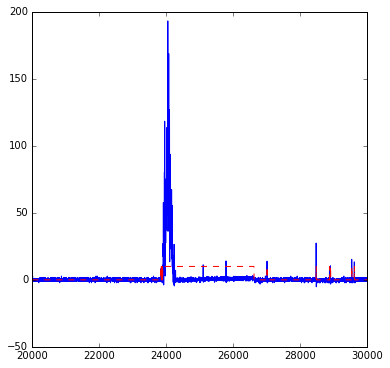

Press a key...
PMT number 6
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 5 with coef_clean = 3.965176e-06 coef_blr = 0.001649618


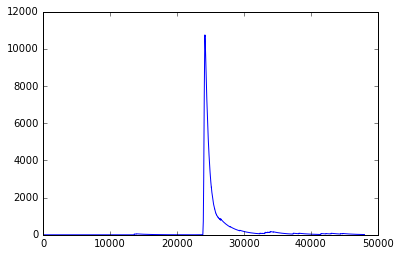

Press a key...


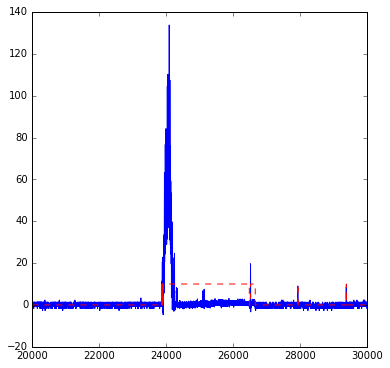

Press a key...
PMT number 7
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 6 with coef_clean = 2.711e-06 coef_blr = 0.001592963


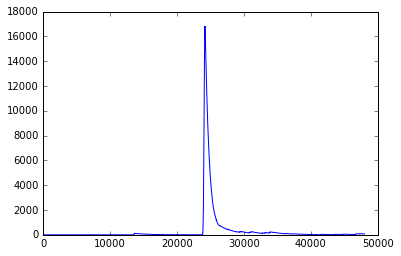

Press a key...


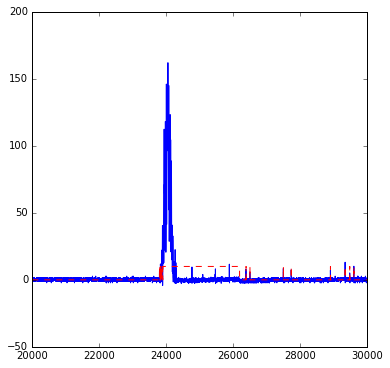

Press a key...
PMT number 8
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 7 with coef_clean = 3.127641e-06 coef_blr = 0.001612068


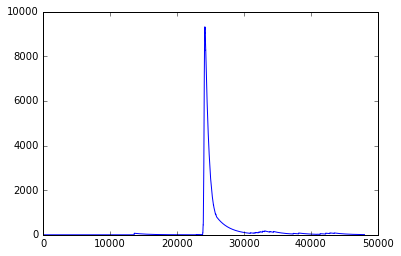

Press a key...


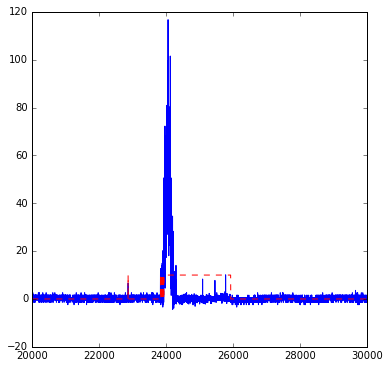

Press a key...
PMT number 9
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 8 with coef_clean = 3.064543e-06 coef_blr = 0.001600683


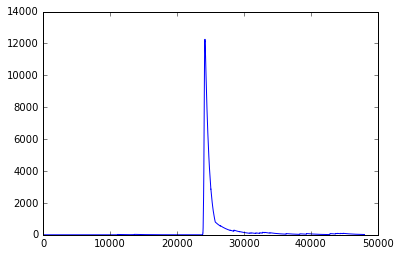

Press a key...


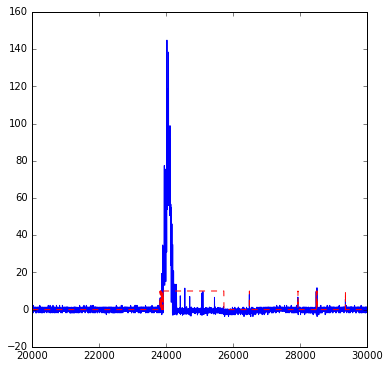

Press a key...
PMT number 10
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 9 with coef_clean = 3.040463e-06 coef_blr = 0.001592718


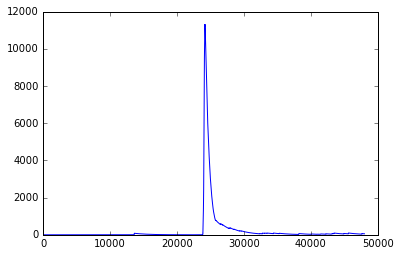

Press a key...


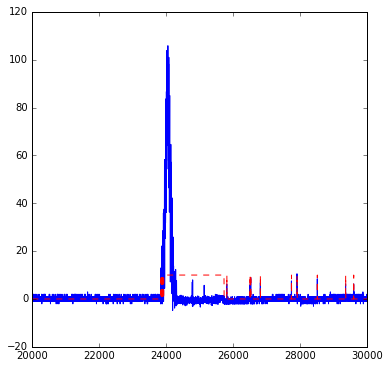

Press a key...
PMT number 11
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 10 with coef_clean = 3.113604e-06 coef_blr = 0.001575192


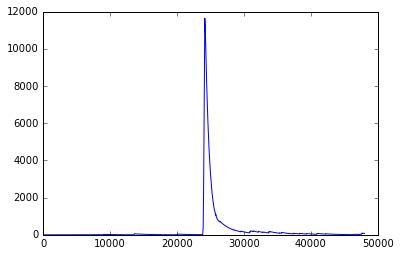

Press a key...


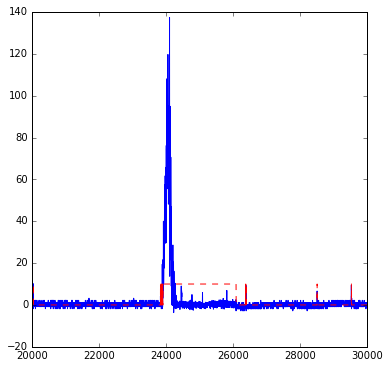

Press a key...
PMT number 12
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 11 with coef_clean = 3.185979e-06 coef_blr = 0.001596322


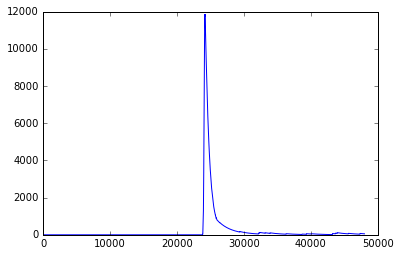

Press a key...


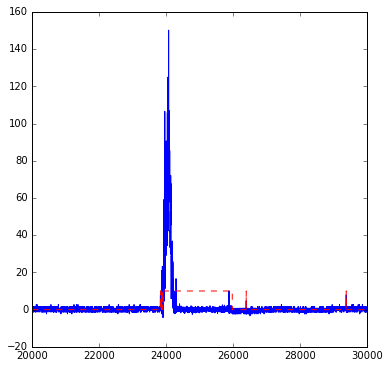

Press a key...


In [103]:
deconv_acum(pmtrwf,dataPMT, thr1 = 5, thr2=800, thr3=0.9995, mau_len=500, 
               xmin=20000,
               xmax=30000, 
               event=0)

#### MUCH BETTER

### Electrons

In [109]:
pmtrwf = e2644.root.RD.pmtrwf

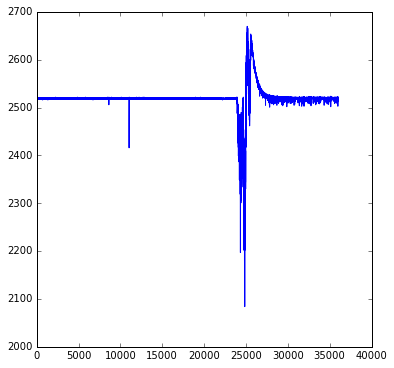

In [110]:
xmin = 0
xmax = 36000
plt.figure(figsize=(6, 6))
plt.plot(range(xmin,xmax),pmtrwf[0,0][xmin:xmax])

PMT number 1
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411


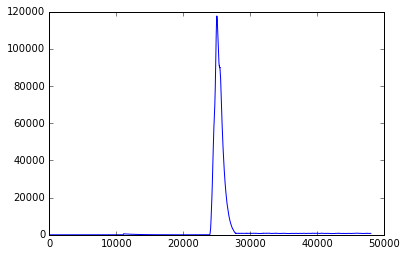

Press a key...


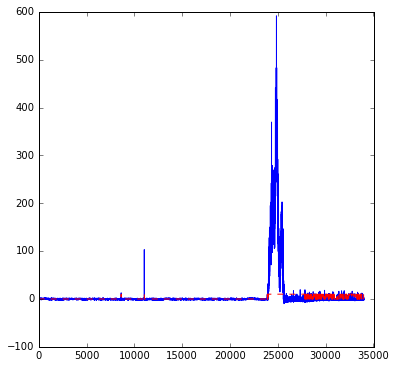

Press a key...
PMT number 2
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 1 with coef_clean = 3.08e-06 coef_blr = 0.001632411


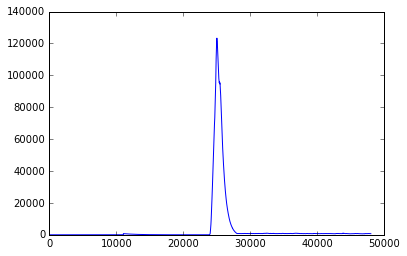

Press a key...


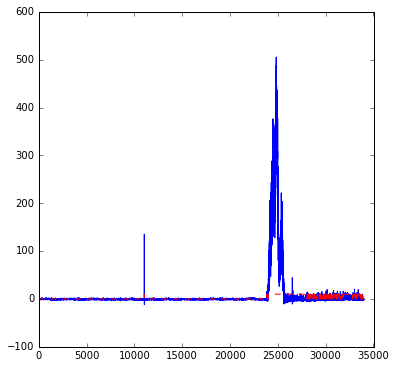

Press a key...
PMT number 3
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 2 with coef_clean = 2.8006e-06 coef_blr = 0.001611104


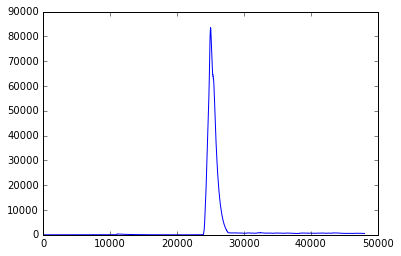

Press a key...


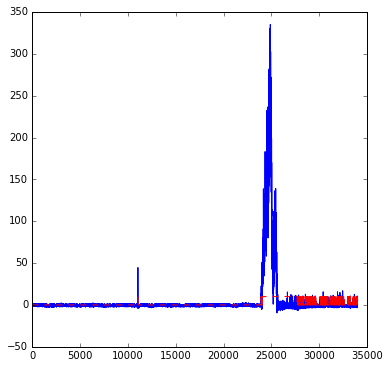

Press a key...
PMT number 4
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 3 with coef_clean = 2.756265e-06 coef_blr = 0.001599356


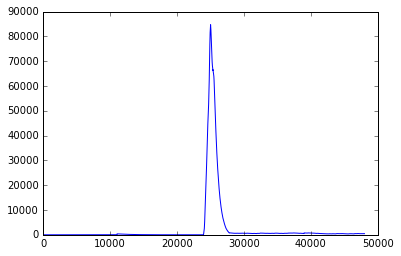

Press a key...


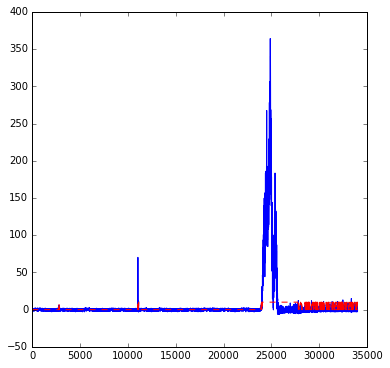

Press a key...
PMT number 5
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 4 with coef_clean = 3.138766e-06 coef_blr = 0.001566958


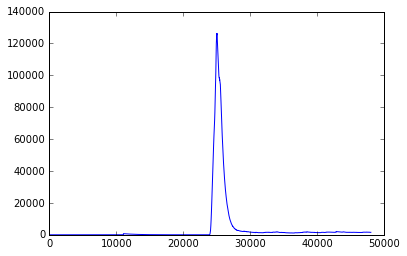

Press a key...


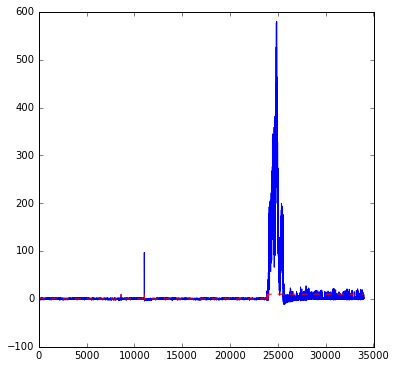

Press a key...
PMT number 6
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 5 with coef_clean = 3.965176e-06 coef_blr = 0.001649618


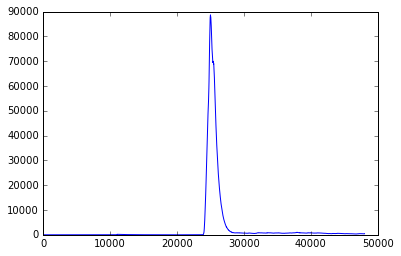

Press a key...


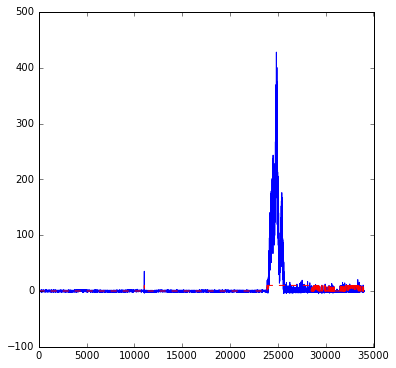

Press a key...
PMT number 7
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 6 with coef_clean = 2.711e-06 coef_blr = 0.001592963


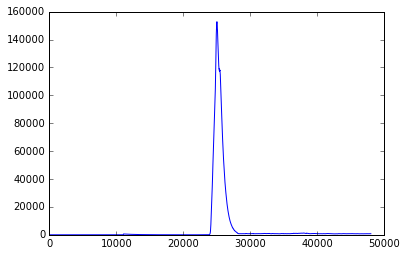

Press a key...


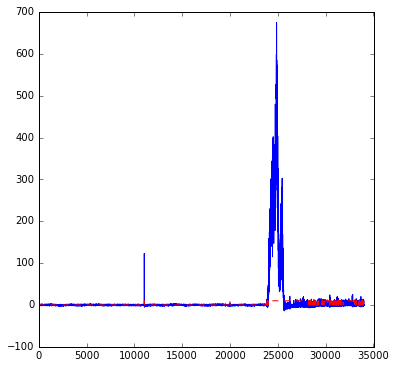

Press a key...
PMT number 8
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 7 with coef_clean = 3.127641e-06 coef_blr = 0.001612068


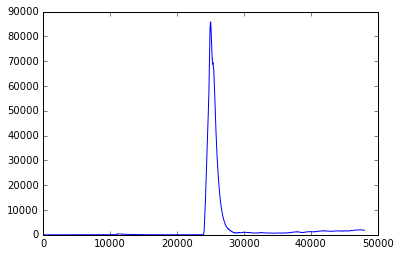

Press a key...


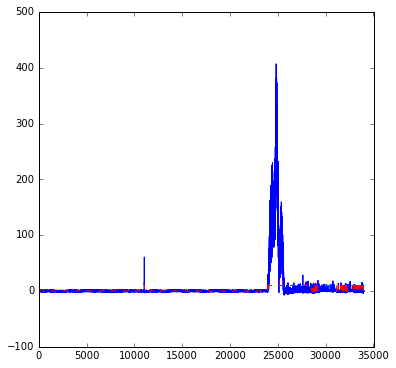

Press a key...
PMT number 9
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 8 with coef_clean = 3.064543e-06 coef_blr = 0.001600683


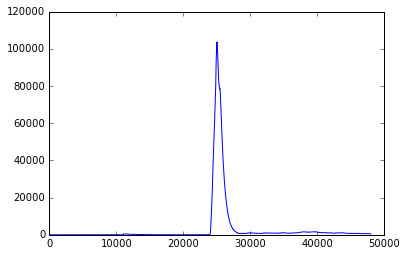

Press a key...


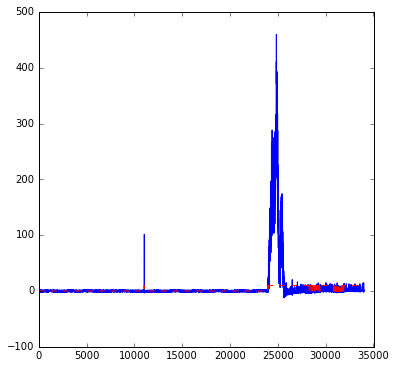

Press a key...
PMT number 10
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 9 with coef_clean = 3.040463e-06 coef_blr = 0.001592718


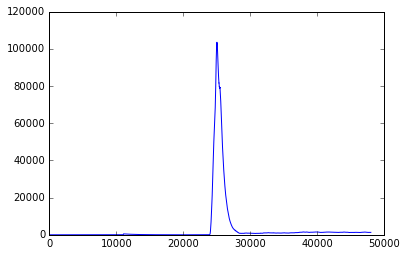

Press a key...


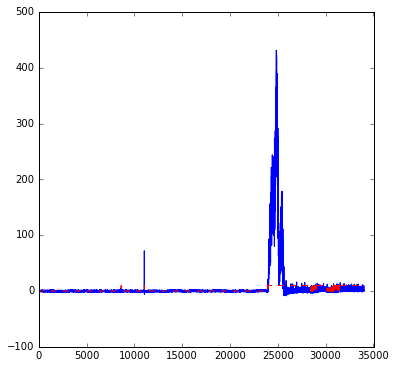

Press a key...
PMT number 11
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 10 with coef_clean = 3.113604e-06 coef_blr = 0.001575192


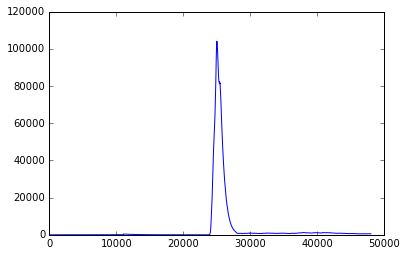

Press a key...


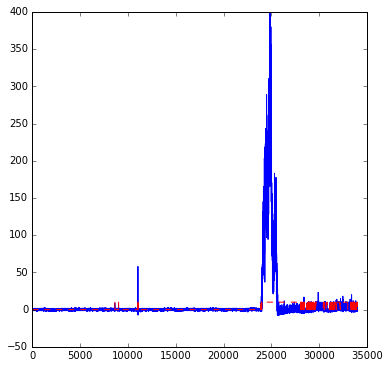

Press a key...
PMT number 12
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 11 with coef_clean = 3.185979e-06 coef_blr = 0.001596322


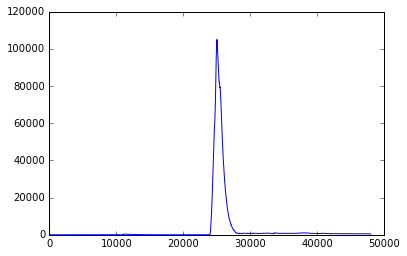

Press a key...


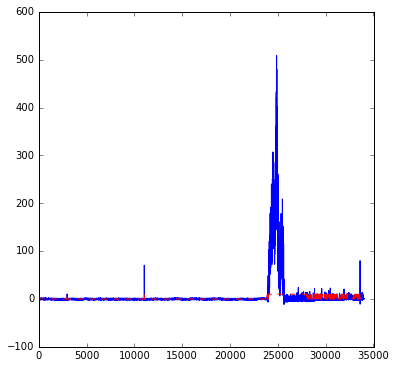

Press a key...


In [111]:
deconv_acum(pmtrwf,dataPMT, thr1 = 5, thr2=800, thr3=0.9995, mau_len=500, 
               xmin=0,
               xmax=34000, 
               event=0)

#### BINGO!

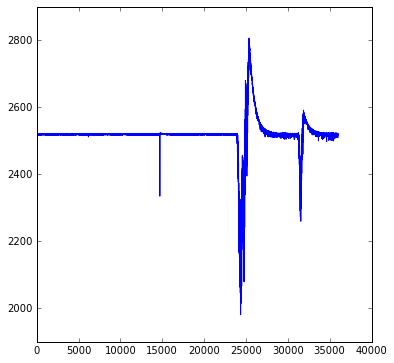

In [107]:
xmin = 0
xmax = 36000
plt.figure(figsize=(6, 6))
plt.plot(range(xmin,xmax),pmtrwf[1,0][xmin:xmax])

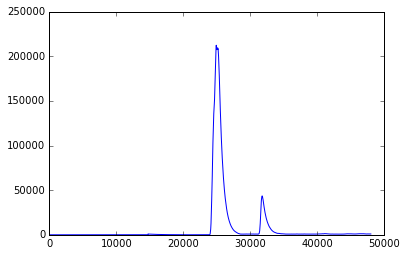

Press a key...


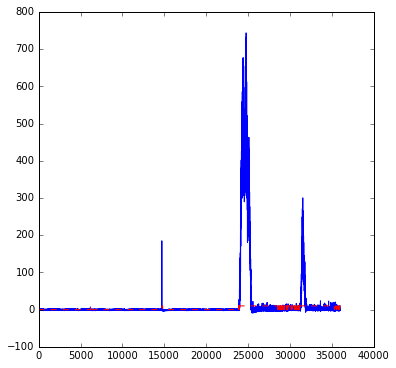

In [ ]:
BLR = deconvolve_signal_acum(pmtrwf[1,0], n_baseline=500, 
                      coef_clean=dataPMT['coef_c'][0], coef_blr=dataPMT['coef_blr'][0], 
                      thr_trigger=5, thr_acum=800, coeff_acum = 0.9995,
                      filter_c=True)
                                                                            
        
plt.plot(BLR['acum'])
plt.show()
wait()
plt.figure(figsize=(6, 6))

plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.show()
wait()